In [1]:
if "google.colab" in str(get_ipython()):
    !pip install PyCO2SYS

In [1]:
import os
from itertools import product
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import PyCO2SYS as csys

import glodap

## Load the GLODAP dataset 

[GLODAP](https://www.glodap.info/) is a observational synthesis of biogeochemical variables over the global ocean.

The `glodap` module provides an interface to these data.

In [3]:
ds = glodap.open_glodap(product="GLODAPv2.2016b_MappedClimatologies")

# subset for surface
ds = ds.isel(depth=0, drop=True)
ds

<xarray.Dataset> Size: 8MB
Dimensions:       (lat: 180, lon: 360, bnds: 2)
Coordinates:
  * lon           (lon) float64 3kB 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
  * lat           (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables: (12/17)
    Cant          (lat, lon) float64 518kB ...
    NO3           (lat, lon) float64 518kB ...
    OmegaA        (lat, lon) float64 518kB ...
    OmegaC        (lat, lon) float64 518kB ...
    PI_TCO2       (lat, lon) float64 518kB ...
    PO4           (lat, lon) float64 518kB ...
    ...            ...
    SALT          (lat, lon) float64 518kB ...
    SiO3          (lat, lon) float64 518kB ...
    TEMP          (lat, lon) float64 518kB ...
    area          (lat, lon) float64 518kB 1.079e+08 1.079e+08 ... 1.079e+08
    depth_bnds    (bnds) float64 16B -5.0 5.0
    dz            float64 8B 10.0
Attributes:
    Description:          1 X 1 global mapped field of anthropogenic carbon c...
    Created:              Created by Siv K. Lauvset on 12-May-2016 18:48:16
    Institution name:     University of Bergen
    Contact information:  siv.lauvset@uib.no; are.olsen@uib.no
    Citation:             Cite as: Lauvset, Siv K., Key, Robert M., Olsen, Ar...

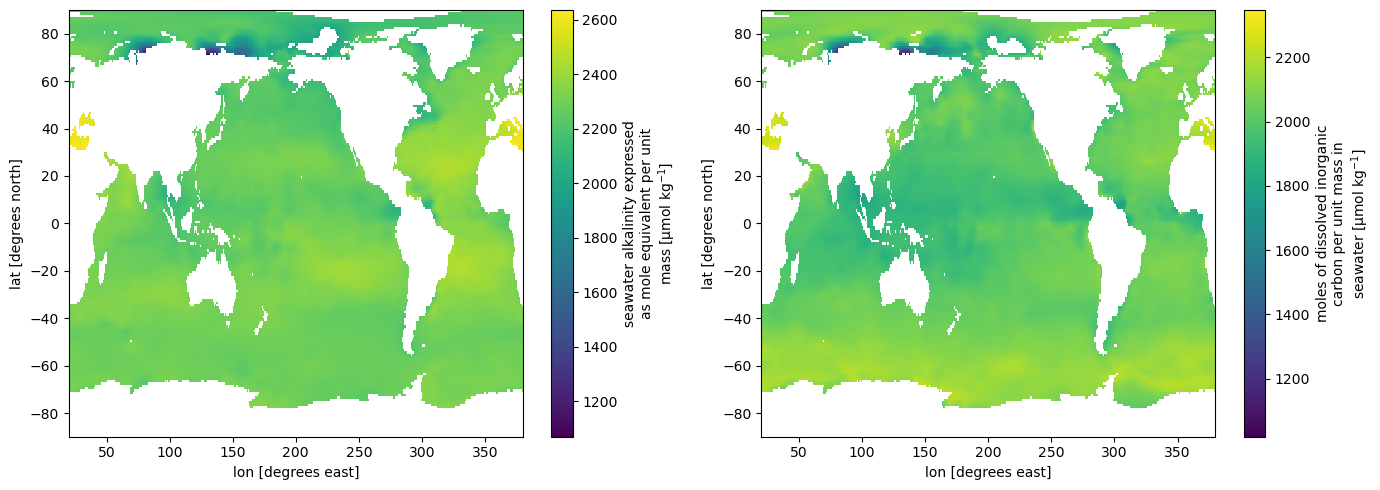

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

ds.ALK.plot(ax=axs[0])
ds.DIC.plot(ax=axs[1])
plt.tight_layout();

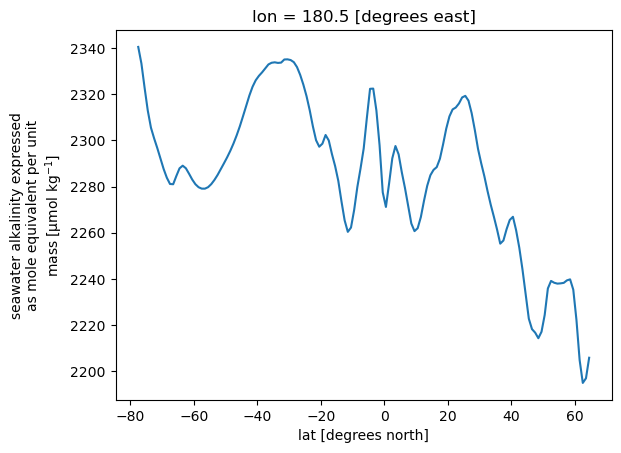

In [5]:
# ds.ALK.sel(lat=slice(64, 66)).plot()
# plt.plot(190, 65, 'ro')
sel_transect = dict(lon=180.5, lat=slice(-78, 65))
ds.ALK.sel(sel_transect).plot()

## Background state information

In [6]:
lon = 200
lat = 35

ds_point = ds.sel(lon=lon, lat=lat, method="nearest")
ocn_state = {
    k: np.round(ds_point[k].values.item(0), 2)
    for k in ["TEMP", "SALT", "ALK", "DIC", "PO4", "SiO3"]
}
ocn_state

{'TEMP': 24.37,
 'SALT': 34.51,
 'ALK': 2261.89,
 'DIC': 1986.98,
 'PO4': 0.12,
 'SiO3': 4.23}

Get some guidance on a sensible range for varying alkalinty

In [7]:
alk_bounds = np.nanpercentile(ds.ALK, [5, 95])
alk_bounds

array([2162.93731689, 2395.07904053])

Set up [PyCO2SYS](https://pyco2sys.readthedocs.io)

In [8]:
# CO2SYS parameter types
par_type = dict(ALK=1, DIC=2, pH=3, pCO2=4)


def csys_renamer(result):
    """Rename PyCO2SYS output to our names"""
    mapper = {
        "saturation_calcite": "Omega_calc",
        "saturation_aragonite": "Omega_arag",
        "alkalinity": "ALK",
        "dic": "DIC",
    }
    for k_old, k_new in mapper.items():
        result[k_new] = result.pop(k_old)
    return result

## CO2 Slider

Figure: CO2 slider: slide atmospheric CO2, show concentrations of CO2, HCO3, and CO3 species, total DIC, pH and Ω

In [9]:
%%time
alk = ocn_state["ALK"]  # µmol/kg

# conditions that vary
index_keys = ["pCO2"]
pco2_range = np.arange(280.0, 560.0, 5.0)

# results to save in the table
result_keys = [
    "DIC",
    "ALK",
    "CO2",
    "HCO3",
    "CO3",
    "pH",
    "Omega_calc",
    "Omega_arag",
]

# precompute equilibrium constants (for performance)
result = csys.sys(
    temperature=ocn_state["TEMP"],
    salinity=ocn_state["SALT"],
)
equil_constants = {k: v for k, v in result.items() if k[:2] == "k_"}

# compute the lookup table
rows = []
for pco2 in pco2_range:
    result = csys.sys(
        par1=pco2,
        par2=alk,
        par1_type=par_type["pCO2"],
        par2_type=par_type["ALK"],
        temperature=ocn_state["TEMP"],
        salinity=ocn_state["SALT"],
        total_silicate=ocn_state["SiO3"],
        total_phosphate=ocn_state["PO4"],
        **equil_constants,
    )
    result = csys_renamer(result)
    rows.append({k: result[k] for k in result_keys + index_keys})

df = pd.DataFrame(rows).set_index(keys=index_keys)
df

CPU times: user 3.69 s, sys: 15.1 ms, total: 3.7 s
Wall time: 4.69 s


,DIC,ALK,CO2,HCO3,CO3,pH,Omega_calc,Omega_arag
pCO2,,,,,,,,
280.0,1902.763418,2261.89,8.072635,1644.457000,250.233782,8.163236,6.041785,3.971491
285.0,1906.645631,2261.89,8.216789,1650.711496,247.717346,8.157197,5.981027,3.931553
290.0,1910.446708,2261.89,8.360944,1656.831043,245.254721,8.151251,5.921568,3.892468
295.0,1914.169441,2261.89,8.505098,1662.820260,242.844083,8.145394,5.863364,3.854208
300.0,1917.816492,2261.89,8.649252,1668.683544,240.483697,8.139624,5.806374,3.816746
305.0,1921.390396,2261.89,8.793406,1674.425084,238.171906,8.133937,5.750557,3.780056
310.0,1924.893568,2261.89,8.937560,1680.048878,235.907130,8.128331,5.695875,3.744111
315.0,1928.328314,2261.89,9.081715,1685.558737,233.687862,8.122804,5.642291,3.708889
320.0,1931.696834,2261.89,9.225869,1690.958304,231.512661,8.117354,5.589772,3.674366


In [10]:
df.to_pickle("data/CO2-slider-DataFrame.pkl")

## Alkalinity slider

Figure: Alkalinity slider: slide alkalinity amount, show concentrations of CO2, HCO3, and CO3 species and total DIC, pH and Ω

Define output dataset

In [11]:
nlat = ds.sizes["lat"]
nlon = ds.sizes["lon"]

# set a range of alkalinity additions
alk_add_range = xr.DataArray(
    data=np.arange(0, 700, 100),
    name="alk_add",
    dims=("alk_add",),
    attrs=dict(units="µmol/kg", long_name="∆Alk"),
)
nalk = len(alk_add_range)

base_var = xr.DataArray(
    data=np.ones((nalk, nlat, nlon)),
    coords=dict(alk_add=alk_add_range, lat=ds.lat, lon=ds.lon),
)

data_vars = dict()
data_vars["DIC"] = xr.full_like(base_var, fill_value=np.nan)
data_vars["DIC"].attrs["units"] = "µmol/kg"
data_vars["DIC"].attrs["long_name"] = "DIC"

data_vars["ALK"] = xr.full_like(base_var, fill_value=np.nan)
data_vars["ALK"].attrs["units"] = "µmol/kg"
data_vars["ALK"].attrs["long_name"] = "ALK"

data_vars["pCO2"] = xr.full_like(base_var, fill_value=np.nan)
data_vars["pCO2"].attrs["units"] = "µatm"
data_vars["pCO2"].attrs["long_name"] = "pCO2"

data_vars["CO2"] = xr.full_like(base_var, fill_value=np.nan)
data_vars["CO2"].attrs["units"] = "µmol/kg"
data_vars["CO2"].attrs["long_name"] = "dissolved CO2"

data_vars["HCO3"] = xr.full_like(base_var, fill_value=np.nan)
data_vars["HCO3"].attrs["units"] = "µmol/kg"
data_vars["HCO3"].attrs["long_name"] = "Bicarbonate ion"

data_vars["CO3"] = xr.full_like(base_var, fill_value=np.nan)
data_vars["CO3"].attrs["units"] = "µmol/kg"
data_vars["CO3"].attrs["long_name"] = "Carbonate ion"

data_vars["pH"] = xr.full_like(base_var, fill_value=np.nan)
data_vars["pH"].attrs["long_name"] = "pH"

data_vars["Omega_calc"] = xr.full_like(base_var, fill_value=np.nan)
data_vars["Omega_calc"].attrs["long_name"] = "Ω (calcite)"

data_vars["Omega_arag"] = xr.full_like(base_var, fill_value=np.nan)
data_vars["Omega_arag"].attrs["long_name"] = "Ω (aragonite)"

result_keys = list(data_vars.keys())

# add variables for "equilibrated" state
for k in result_keys:
    data_vars[k + "_equil"] = xr.full_like(data_vars[k], fill_value=np.nan)

# and one last variable, the efficiency
data_vars["eta_max"] = xr.full_like(base_var, fill_value=np.nan)
data_vars["eta_max"].attrs["units"] = "mol/mol"
data_vars["eta_max"].attrs["long_name"] = "∆DIC/∆ALK (max)"

# instantiate Dataset
ds_out = xr.Dataset(
    data_vars=data_vars,
    coords=dict(lon=ds.lon, lat=ds.lat),
    attrs=dict(description="GLODAP-based calculations of OAE anomalies using PyCO2SYS"),
)

ds_out

<xarray.Dataset> Size: 69MB
Dimensions:           (alk_add: 7, lat: 180, lon: 360)
Coordinates:
  * alk_add           (alk_add) int64 56B 0 100 200 300 400 500 600
  * lat               (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon               (lon) float64 3kB 20.5 21.5 22.5 ... 377.5 378.5 379.5
Data variables: (12/19)
    DIC               (alk_add, lat, lon) float64 4MB nan nan nan ... nan nan
    ALK               (alk_add, lat, lon) float64 4MB nan nan nan ... nan nan
    pCO2              (alk_add, lat, lon) float64 4MB nan nan nan ... nan nan
    CO2               (alk_add, lat, lon) float64 4MB nan nan nan ... nan nan
    HCO3              (alk_add, lat, lon) float64 4MB nan nan nan ... nan nan
    CO3               (alk_add, lat, lon) float64 4MB nan nan nan ... nan nan
    ...                ...
    HCO3_equil        (alk_add, lat, lon) float64 4MB nan nan nan ... nan nan
    CO3_equil         (alk_add, lat, lon) float64 4MB nan nan nan ... nan nan
    pH_equil          (alk_add, lat, lon) float64 4MB nan nan nan ... nan nan
    Omega_calc_equil  (alk_add, lat, lon) float64 4MB nan nan nan ... nan nan
    Omega_arag_equil  (alk_add, lat, lon) float64 4MB nan nan nan ... nan nan
    eta_max           (alk_add, lat, lon) float64 4MB nan nan nan ... nan nan
Attributes:
    description:  GLODAP-based calculations of OAE anomalies using PyCO2SYS

In [12]:
%%time

# confirm expectation
assert alk_add_range[0] == 0

for i, alk_add in enumerate(alk_add_range.values):
    # compute pre-equilibrated result
    plus_alk = csys.sys(
        par1=ds.DIC,
        par2=ds.ALK + alk_add,
        par1_type=par_type["DIC"],
        par2_type=par_type["ALK"],
        temperature=ds.TEMP,
        salinity=ds.SALT,
        total_silicate=ds.SiO3,
        total_phosphate=ds.PO4,
    )
    plus_alk = csys_renamer(plus_alk)

    # save the pCO2 at the initial state
    # equilibration restores the system to this value
    if i == 0:
        DIC_initial = plus_alk["DIC"]
        pCO2_initial = plus_alk["pCO2"]

    # compute equilibrated result
    plus_alk_equil = csys.sys(
        par1=pCO2_initial,
        par2=ds.ALK + alk_add,
        par1_type=par_type["pCO2"],
        par2_type=par_type["ALK"],
        temperature=ds.TEMP,
        salinity=ds.SALT,
        total_silicate=ds.SiO3,
        total_phosphate=ds.PO4,
    )
    plus_alk_equil = csys_renamer(plus_alk_equil)

    for k in result_keys:
        ds_out[k][i, :, :] = plus_alk[k]
        ds_out[k + "_equil"][i, :, :] = plus_alk_equil[k]

    if i > 0:
        ds_out["eta_max"][i, :, :] = (plus_alk_equil["DIC"] - DIC_initial) / alk_add

CPU times: user 24.2 s, sys: 3.79 s, total: 28 s
Wall time: 29.2 s


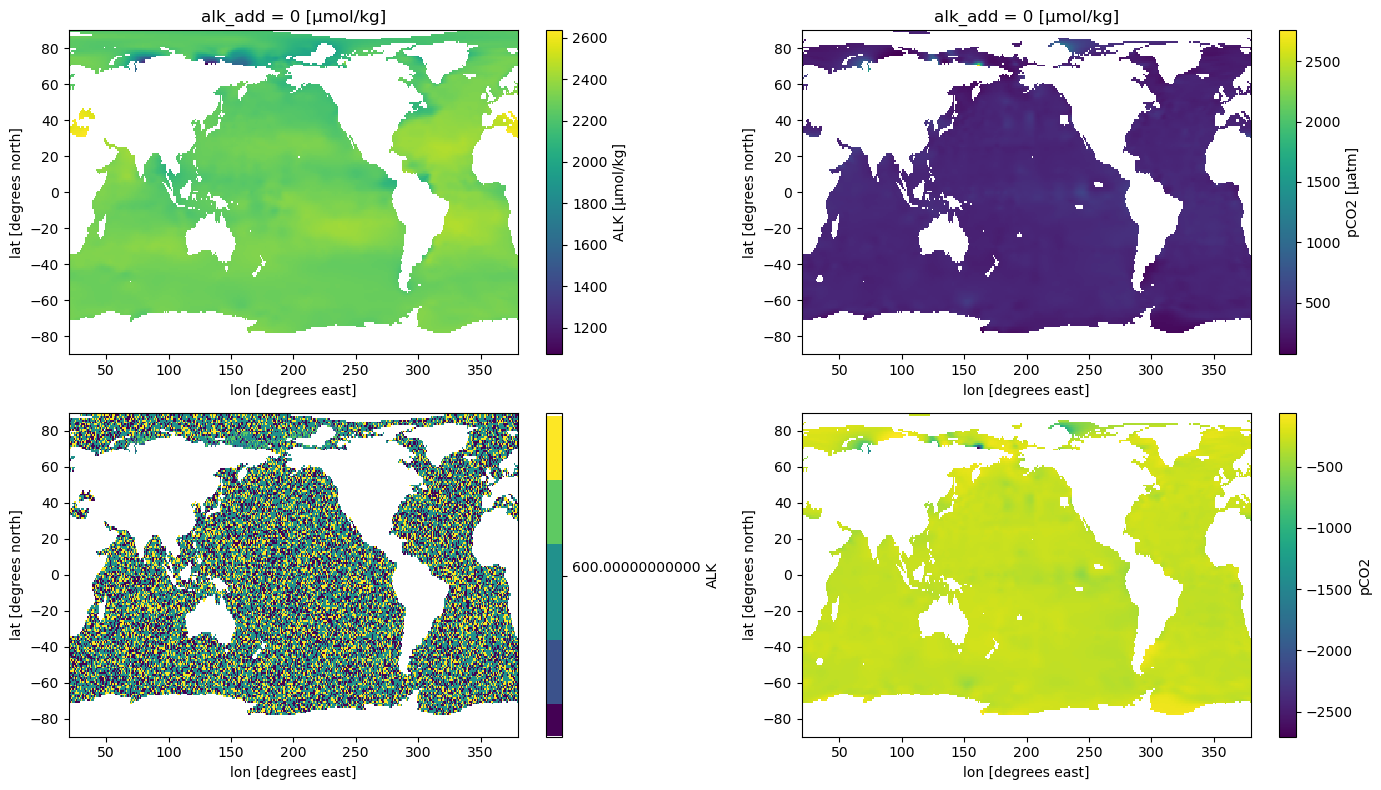

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

ds_out.ALK.isel(alk_add=0).plot(ax=axs[0, 0])
ds_out.pCO2.isel(alk_add=0).plot(ax=axs[0, 1])

(ds_out.ALK.isel(alk_add=-1) - ds_out.ALK.isel(alk_add=0)).plot(ax=axs[1, 0])
(ds_out.pCO2.isel(alk_add=-1) - ds_out.pCO2.isel(alk_add=0)).plot(ax=axs[1, 1])

plt.tight_layout();

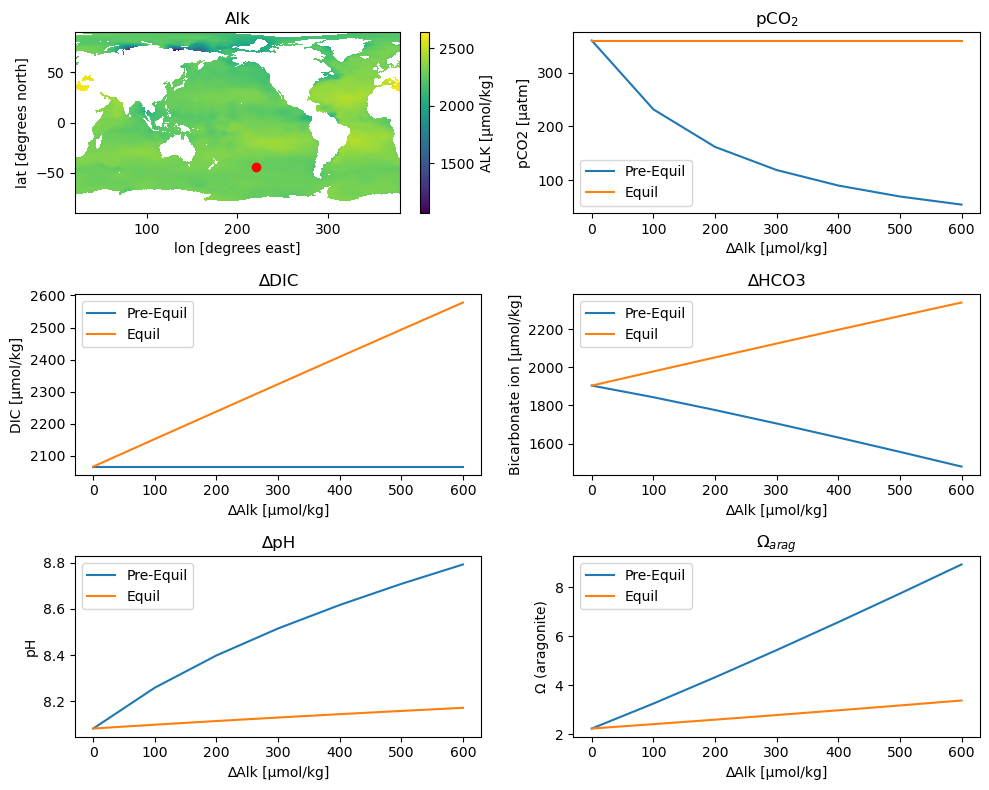

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8))

isel_point = dict(lon=200, lat=45)
lon = ds_out.isel(isel_point).lon
lat = ds_out.isel(isel_point).lat

# map
ds_out.ALK.isel(alk_add=0).plot(ax=axs[0, 0])
axs[0, 0].plot(lon, lat, "ro")
axs[0, 0].set_title("Alk")

ds_out.pCO2.isel(isel_point).plot(ax=axs[0, 1], label="Pre-Equil")
ds_out.pCO2_equil.isel(isel_point).plot(ax=axs[0, 1], label="Equil")
axs[0, 1].legend()
axs[0, 1].set_title("pCO$_2$")

ds_out.DIC.isel(isel_point).plot(ax=axs[1, 0], label="Pre-Equil")
ds_out.DIC_equil.isel(isel_point).plot(ax=axs[1, 0], label="Equil")
axs[1, 0].legend()
axs[1, 0].set_title("∆DIC")

ds_out.HCO3.isel(isel_point).plot(ax=axs[1, 1], label="Pre-Equil")
ds_out.HCO3_equil.isel(isel_point).plot(ax=axs[1, 1], label="Equil")
axs[1, 1].legend()
axs[1, 1].set_title("∆HCO3")

ds_out.pH.isel(isel_point).plot(ax=axs[2, 0], label="Pre-Equil")
ds_out.pH_equil.isel(isel_point).plot(ax=axs[2, 0], label="Equil")
axs[2, 0].legend()
axs[2, 0].set_title("∆pH")

ds_out.Omega_arag.isel(isel_point).plot(ax=axs[2, 1], label="Pre-Equil")
ds_out.Omega_arag_equil.isel(isel_point).plot(ax=axs[2, 1], label="Equil")
axs[2, 1].legend()
axs[2, 1].set_title("$\Omega_{arag}$")

plt.tight_layout();

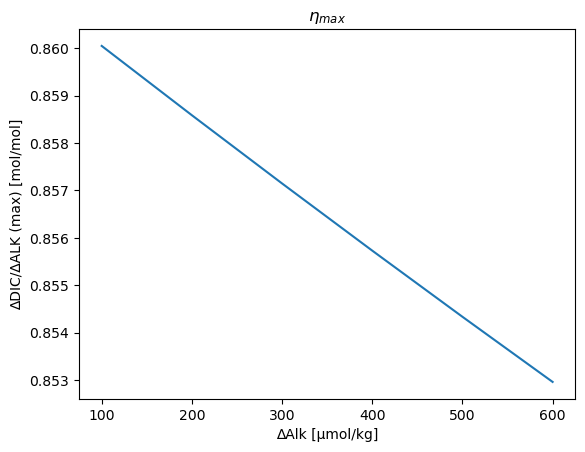

In [15]:
ds_out.eta_max.isel(isel_point).plot()
plt.title("$\eta_{max}$");

In [16]:
os.makedirs("data", exist_ok=True)
ds_out.chunk(lat=10, lon=10).to_zarr(
    "data/glodap-oae.zarr",
    mode="w",
    consolidated=True,
);